# Projet

In [12]:
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
import torch 
import librosa
from os import listdir
import re
import audioread


In [2]:
dict_classes = {
    0: 'portuguese',
    1: 'china',
    2: 'french',
    3: 'quebec',
    4: 'maroc',
    5: 'japon',
    6: 'american',
    7: 'english',
    8: 'korean',
    9: 'spain',
    10: 'italy',
    11: 'tunis'
    }

dict_classes_inv = {
    'portuguese': 0,
    'china': 1,
    'french': 2,
    'quebec': 3,
    'maroc': 4,
    'japon': 5,
    'american': 6,
    'english': 7,
    'korean': 8,
    'spain': 9,
    'italy': 10,
    'tunis': 11
    }
list_genres = ['M', 'F']

In [3]:
import glob
import re
import librosa
import numpy as np

# Initialisation des listes et des variables
data = []  # Contiendra les données audio
labels = []  # Contiendra les labels des langues
genres = []  # Contiendra les genres (M/F)
names = []  # Contiendra les noms des fichiers
min_duration = None  # Durée minimale en échantillons

# Parcourir tous les fichiers MP3 dans le dossier 'clips'
for file_name in glob.glob('clips/*.mp3'):
    try:
        # Ajout des noms de fichiers
        names.append(file_name)
        
        # Chargement de l'audio avec librosa
        audio, sr = librosa.load(file_name, sr=None)  # sr=None pour conserver la fréquence d'échantillonnage d'origine
        
        # Ajout des données audio
        data.append(audio)
        
        # Calcul de la durée minimale
        if min_duration is None or len(audio) < min_duration:
            print(file_name)
            min_duration = len(audio)
        
        # # Création du vecteur des labels des langues
        # for i, word in enumerate(languages):
        #     if re.search(word, file_name, re.IGNORECASE):  # Recherche insensible à la casse
        #         labels.append(i)
        #         break  # Une seule correspondance par fichier

        for key, word in dict_classes.items():
            if re.search(word, file_name, re.IGNORECASE):  # Recherche insensible à la casse
                labels.append(key)
                break  # Une seule correspondance par fichier
        
        # Création du vecteur des genres
        for genre in list_genres:
            if re.search(genre, file_name, re.IGNORECASE):  # Recherche insensible à la casse
                genres.append(genre)
                break  # Une seule correspondance par fichier
        
    except Exception as e:
        print(f"Erreur lors du traitement du fichier {file_name}: {e}")

# Conversion en tableaux NumPy pour une manipulation plus facile
data = np.array(data, dtype=object)  # Utiliser dtype=object pour des séquences audio de différentes longueurs
labels = np.array(labels)
genres = np.array(genres)

# Affichage des informations finales
print(f"La plus petite durée d'enregistrement est {min_duration} échantillons.")
print(f"la fréquence d'échantillonnage est {sr} Hz.")
print(f"Le nombre de fichiers traités est {len(data)}.")


clips/quebec_H_27.mp3
clips/tunis_H_17.mp3
La plus petite durée d'enregistrement est 176400 échantillons.
la fréquence d'échantillonnage est 48000 Hz.
Le nombre de fichiers traités est 1200.


In [4]:
def trim(record, min_duration):
    half_duration = min_duration//2

    # First, we compute the barycenter of energy along time. We interpret it as the moment when the word appears
    barycenter = int(np.floor(np.multiply(np.power(record,2),np.arange(0,record.shape[0],1)).sum()/np.power(record,2).sum()))

    # Second, we adjust the barycenter to be in the index range
    if barycenter-half_duration < 0:
        barycenter += half_duration-barycenter
    if barycenter+half_duration >= record.shape[0]:
        barycenter -= barycenter+half_duration - record.shape[0]
    
    # Finally, we trim the recording around the barycenter 
    return record[barycenter-half_duration:barycenter+half_duration]

In [5]:
X = np.empty((len(data),min_duration))
for i in range(len(data)):
    X[i,:] = trim(data[i], min_duration)

y = np.array(labels)
print(f'Shape of inputs X is{X.shape} and size of targets class is {y.shape}')

Shape of inputs X is(1200, 176400) and size of targets class is (1200,)


### Réduction de dimension

#### STFT

In [6]:
from sklearn.preprocessing import StandardScaler

X_scale = StandardScaler().fit_transform(X)

Shape of the spectrogram is (257, 345)


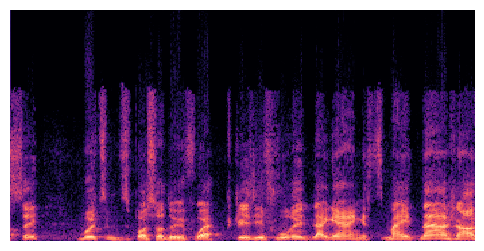

In [7]:
# Calculer le spectrogramme
stft_result = librosa.stft(X_scale[0], n_fft=512, hop_length=512)
spectrogram = np.abs(stft_result)
spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)

# Créer le graphique du spectrogramme (sans axes ni titre)
plt.figure(figsize=(6, 3))
plt.axis('off')  # Désactiver les axes
librosa.display.specshow(spectrogram_db, sr=None, hop_length=512,
                            x_axis=None, y_axis=None, cmap="magma")

print(f"Shape of the spectrogram is {spectrogram_db.shape}")

In [8]:
# obtenir X_stft
X_stft = np.empty((X_scale.shape[0], spectrogram_db.shape[0], spectrogram_db.shape[1]))
for i in range(X_scale.shape[0]):
    stft_result = librosa.stft(X_scale[i], n_fft=512, hop_length=512)
    spectrogram = np.abs(stft_result)
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    X_stft[i] = spectrogram_db

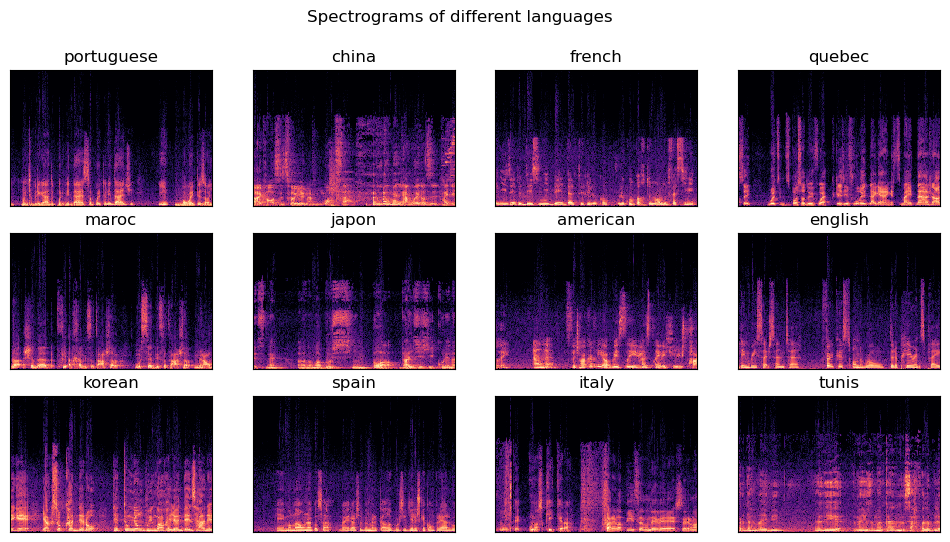

In [9]:
# afficher sur la même figure un spectrogramme pour chaque langue
plt.figure(figsize=(12, 6))
plt.axis('off')
for i in range(12):
    plt.subplot(3, 4, i+1)
    index = np.where(y == i)[0][0]
    plt.title(dict_classes[i])
    librosa.display.specshow(X_stft[index], sr=None, hop_length=512,
                             x_axis=None, y_axis=None, cmap="magma")

plt.suptitle("Spectrograms of different languages")
plt.show()

In [13]:
if not os.path.exists('spectrograms_clips'):
    os.makedirs('spectrograms_clips')

for i in range(X_stft.shape[0]):
    np.save(f'spectrograms_clips/{names[i].split("/")[-1].split(".")[0]}.npy', X_stft[i])
    print(f'spectrograms_clips/{names[i].split("/")[-1].split(".")[0]}.npy' + ' saved')

spectrograms_clips/quebec_H_27.npy saved
spectrograms_clips/american_F_38.npy saved
spectrograms_clips/maroc_H_12.npy saved
spectrograms_clips/french_F_19.npy saved
spectrograms_clips/english_F_49.npy saved
spectrograms_clips/quebec_H_37.npy saved
spectrograms_clips/quebec_H_45.npy saved
spectrograms_clips/tunis_H_17.npy saved
spectrograms_clips/china_H_29.npy saved
spectrograms_clips/korean_F_40.npy saved
spectrograms_clips/japon_H_46.npy saved
spectrograms_clips/portuguese_H_6.npy saved
spectrograms_clips/china_H_4.npy saved
spectrograms_clips/china_H_37.npy saved
spectrograms_clips/italy_H_7.npy saved
spectrograms_clips/quebec_H_34.npy saved
spectrograms_clips/japon_F_33.npy saved
spectrograms_clips/spain_F_6.npy saved
spectrograms_clips/korean_F_48.npy saved
spectrograms_clips/english_F_21.npy saved
spectrograms_clips/maroc_F_40.npy saved
spectrograms_clips/french_H_29.npy saved
spectrograms_clips/english_F_5.npy saved
spectrograms_clips/korean_F_50.npy saved
spectrograms_clips/ame